In [10]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly
import plotly.plotly as py
from statsmodels.tsa.stattools import grangercausalitytests

In [11]:
crime_df = pd.read_csv(os.path.join('formatted','crimes.csv'))
median_income_df = pd.read_csv(os.path.join('formatted','median_income.csv'))
unemployment_df = pd.read_csv(os.path.join('formatted','unemployment.csv'))

Set State as the index for clearer accesibility

In [12]:
crime_df.set_index('State', inplace=True)
median_income_df.set_index('State', inplace=True)
unemployment_df.set_index('State', inplace=True)

Consolidate the name of Districs of Columbia to be "DC" for all DataFrames. And drop "Unites States" 

In [13]:
unemployment_df.rename(index={'District of Columbia':'DC'}, inplace=True)
median_income_df.rename(index={'D.C.':'DC'}, inplace=True)
median_income_df = median_income_df.drop('United States')

Median income date is listed in descending order and spans data all the way to 1984. We correct the DataFrame to include only years from 1995 -like the other DataFrames- and have rows listed in increasing temporal order

In [14]:
median_columns = list(median_income_df.columns)
median_columns.sort()
median_columns = median_columns[11:]
median_income_df = median_income_df[median_columns]
median_income_df.head()

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
State,,,,,,,,,,,,,,,,,,,,,
AL,25991,30302,31939,36266,36251,35424,35160,37603,37255,36629,...,42212,44476,39980,40933,42590,43464,47320,42278,44509,47221
AK,47954,52779,47994,50692,51396,52847,57363,52774,51837,55063,...,62993,63989,61604,57848,57431,63648,72472,67629,75112,75723
AZ,30863,31637,32740,37090,36995,39783,42704,39734,41166,43846,...,47215,46914,45739,46896,48621,47044,52611,49254,52248,57100
AR,25814,27123,26162,27665,29682,29697,33339,32387,32002,34984,...,40795,39586,36538,38587,41302,39018,39376,44922,42798,45907
CA,37009,38812,39694,40934,43629,46816,47262,47437,49300,49222,...,55734,57014,56134,54283,53367,57020,60794,60487,63636,66637


### Granger Causality test for Arkansas

The purpose of the follwoing analysis is to determine if the median income or unemployment time series information can be used to predict future crime rates. We will use the [Granger Causality](http://www.scholarpedia.org/article/Granger_causality) test in order to determine the predictive power of those two variables. In the Granger Causality test two series are compared. 

* A value for series **X** at time *t* is modeled via linear regression using as parameters the values at t-1, t-2,.., t-j for a choser lag j. 
* The value for seres **X** at ttie *t* is modeled again but incliding parameters for the second series **Y** at t-,. t-2, .., t-j
* A statistical test is performed to determined whether adding the previous values of **Y** helped modeled the current value of **X** better.

We use the [statsmodel](https://www.statsmodels.org/stable/index.html) module's implementation of the Granger Causality test. This implementation starts from the null hypothesis that two time series do not **Granger Cause** the other and then p-values are calculates to confirm or reject the hypothesis

In [33]:
#Helper function to remove stationarity of a time series via differentiation
def diff_data(data, lag=1):
    '''Input: data as pandas Series and lag
       Output: pandas series seiers[n] = series[n] - series[n-lag]'''
    if lag == 0:
        return pd.Series(data.iloc[:])
    up = data.iloc[lag:]  
    down = data.iloc[:-lag]
    up.values  - down.values
    return pd.Series(up.values - down.values, index=up.index)

        

In [34]:
def plot_state_lag(state='AK', lag = 1):
    fig, axes = plt.subplots(1,3,figsize=(15,10))
    labels = ['crime rate', 'unemployment', 'median income']
    data = [crime_df, unemployment_df, median_income_df]
    data = [diff_data(data.loc[state,:], lag) for data in data]
    for ax, label, data in zip(axes, labels, data):
        x_axis_labels = list (data.index.values)
        x_axis_values = list (range(len(x_axis_labels)))
        ax.plot(x_axis_values, data, label=label,marker='o')
        ax.set_xticks(x_axis_values)
        ax.set_xticklabels(x_axis_labels,rotation='45')
        ax.legend()
    plt.tight_layout()
    plt.show()


Let's pick Arkansa as an example

Crime rate and median income show some signs of non-stationarity

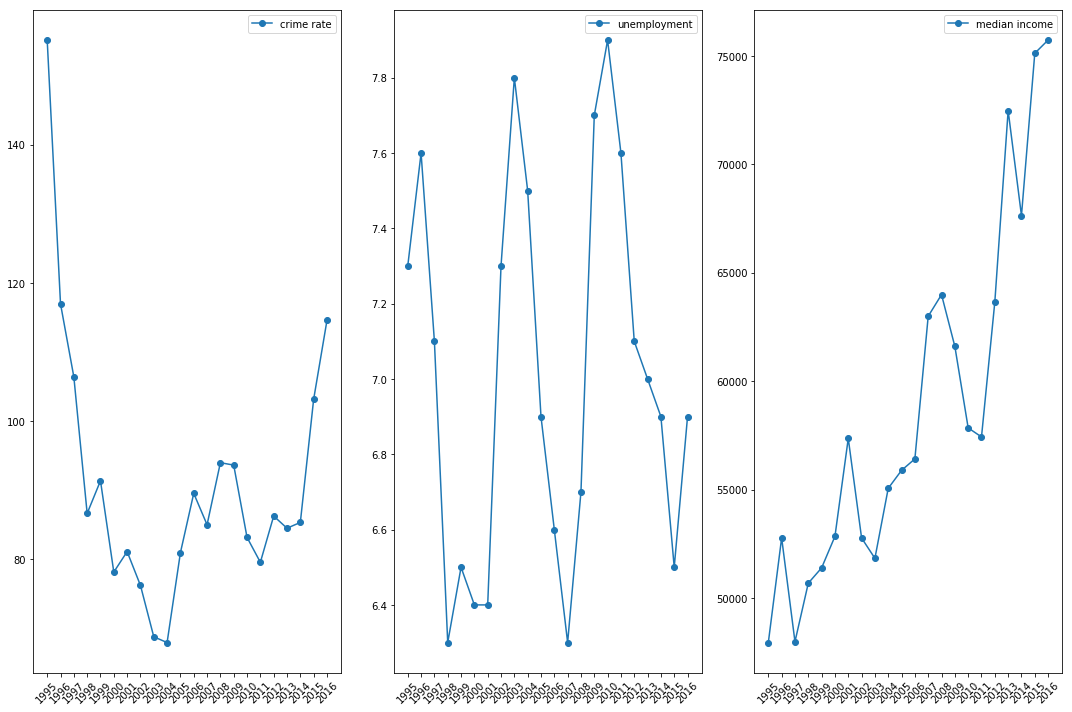

In [35]:
plot_state_lag('AK', lag=0)

Remove stationarity by using a lag-1 difference

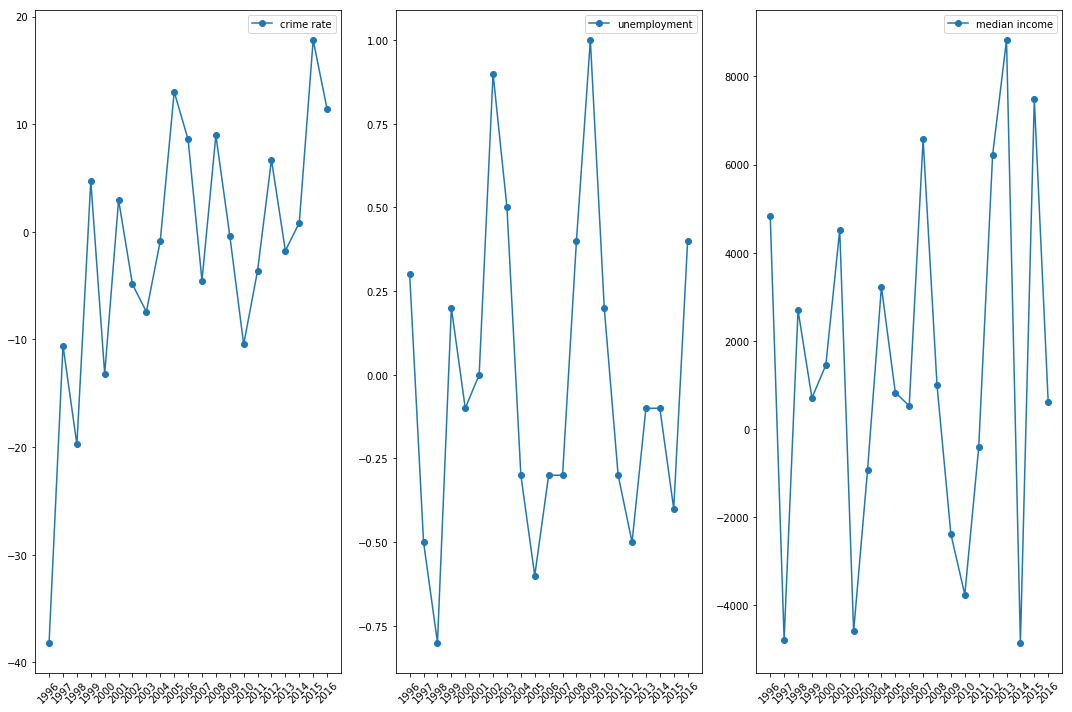

In [36]:
plot_state_lag('AK', 1)

Write a function that converts the data from 2 DataFrames into a single array that can be used in the *grangercausality* funtion.
Include a transformation with lag to remove sationarity of our time series

In [37]:
def make_array(dataframe1,dataframe2, state, lag=1):
    '''Input dataframe1, 2: dataframes that will ge transformed
             state: state to transform
       Output: array (observariont, 2) of the transformed data for both dataframes'''
    return np.stack([diff_data(dataframe1.loc[state,:],lag), diff_data(dataframe2.loc[state,:],lag)], axis=1)
    #return np.stack([dataframe1.loc[state,:], dataframe2.loc[state,:]], axis=1)

In [38]:
ak_stationary = make_array(crime_df, unemployment_df, 'AK',1)
ak_results = grangercausalitytests(ak_stationary, maxlag=6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1768  , p=0.0926  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=3.7374  , p=0.0532  , df=1
likelihood ratio test: chi2=3.4264  , p=0.0642  , df=1
parameter F test:         F=3.1768  , p=0.0926  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1865  , p=0.0376  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=11.3633 , p=0.0034  , df=2
likelihood ratio test: chi2=8.9071  , p=0.0116  , df=2
parameter F test:         F=4.1865  , p=0.0376  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1714  , p=0.0336  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=20.4779 , p=0.0001  , df=3
likelihood ratio test: chi2=13.6748 , p=0.0034  , df=3
parameter F test:         F=4.1714  , p=0.0336  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4349  , p=0.0647  , df_d

The statsmodels module uses four different tests to confirm/reject Granger Causality via p values. We will plot all four p values in our analysis

In [45]:
tests = ['lrtest', 'params_ftest','ssr_chi2test', 'ssr_ftest']
states = crime_df.index
granger_crime_unemp_df = pd.DataFrame()
granger_crime_income_df = pd.DataFrame()

In [46]:
for state in states:
    print(f'State: {state}')
    
    stationary = make_stationary(crime_df, unemployment_df, state,1)
    results = grangercausalitytests(stationary, maxlag=1)
    get_p_val = []
    for test in tests:
        get_p_val.append(results[1][0][test][1])
    granger_crime_unemp_df[state] = get_p_val


State: AK

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1768  , p=0.0926  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=3.7374  , p=0.0532  , df=1
likelihood ratio test: chi2=3.4264  , p=0.0642  , df=1
parameter F test:         F=3.1768  , p=0.0926  , df_denom=17, df_num=1
State: AL

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8532  , p=0.0180  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=8.0626  , p=0.0045  , df=1
likelihood ratio test: chi2=6.7741  , p=0.0092  , df=1
parameter F test:         F=6.8532  , p=0.0180  , df_denom=17, df_num=1
State: AR

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3799  , p=0.5458  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=0.4469  , p=0.5038  , df=1
likelihood ratio test: chi2=0.4420  , p=0.5061  , df=1
parameter F test:         F=0.3799  , p=0.5458  , df_denom=17, df_num=1
State: AZ

Granger Causality
number of lags (no zero) 1
ssr based F te

In [47]:
granger_crime_unemp_df.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0.064162,0.009249,0.506149,0.002172,0.267470,0.787177,0.515056,0.843323,0.311104,0.075037,...,0.233654,0.121263,0.004539,0.213354,0.255511,0.098393,0.066869,0.169363,0.206309,0.255697
1,0.092560,0.018002,0.545823,0.005323,0.313683,0.806242,0.554227,0.857497,0.357421,0.105733,...,0.279197,0.159151,0.009890,0.258204,0.301551,0.133166,0.095866,0.211789,0.250860,0.301741
2,0.053207,0.004519,0.503792,0.000533,0.260092,0.786988,0.512823,0.843248,0.304873,0.063861,...,0.225347,0.110225,0.001637,0.204486,0.247807,0.087126,0.055845,0.159326,0.197247,0.247999
3,0.092560,0.018002,0.545823,0.005323,0.313683,0.806242,0.554227,0.857497,0.357421,0.105733,...,0.279197,0.159151,0.009890,0.258204,0.301551,0.133166,0.095866,0.211789,0.250860,0.301741


In [48]:
for state in states:
    print(f'State: {state}')
    
    stationary = make_stationary(crime_df, median_income_df, state,1)
    results = grangercausalitytests(stationary, maxlag=1)
    get_p_val = []
    for test in tests:
        get_p_val.append(results[1][0][test][1])
    granger_crime_income_df[state] = get_p_val

State: AK

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1317  , p=0.3023  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=1.3314  , p=0.2486  , df=1
likelihood ratio test: chi2=1.2890  , p=0.2562  , df=1
parameter F test:         F=1.1317  , p=0.3023  , df_denom=17, df_num=1
State: AL

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2232  , p=0.6426  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=0.2626  , p=0.6084  , df=1
likelihood ratio test: chi2=0.2609  , p=0.6095  , df=1
parameter F test:         F=0.2232  , p=0.6426  , df_denom=17, df_num=1
State: AR

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1114  , p=0.3065  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=1.3075  , p=0.2528  , df=1
likelihood ratio test: chi2=1.2666  , p=0.2604  , df=1
parameter F test:         F=1.1114  , p=0.3065  , df_denom=17, df_num=1
State: AZ

Granger Causality
number of lags (no zero) 1
ssr based F te

In [49]:
granger_crime_income_df.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0.256242,0.609534,0.26041,0.307318,0.397683,0.473066,0.178481,0.760251,0.255729,0.462050,...,0.338107,0.689779,0.626541,0.914529,0.114112,0.260803,0.909117,0.985047,0.305231,0.445791
1,0.302295,0.642637,0.30653,0.353656,0.442240,0.514484,0.221526,0.781602,0.301773,0.504003,...,0.384127,0.716876,0.658428,0.922324,0.151104,0.306929,0.917402,0.986415,0.351578,0.488489
2,0.248558,0.608365,0.25284,0.300991,0.393446,0.470208,0.168676,0.759980,0.248031,0.459010,...,0.332542,0.689193,0.625518,0.914517,0.102977,0.253244,0.909103,0.985047,0.298850,0.442472
3,0.302295,0.642637,0.30653,0.353656,0.442240,0.514484,0.221526,0.781602,0.301773,0.504003,...,0.384127,0.716876,0.658428,0.922324,0.151104,0.306929,0.917402,0.986415,0.351578,0.488489


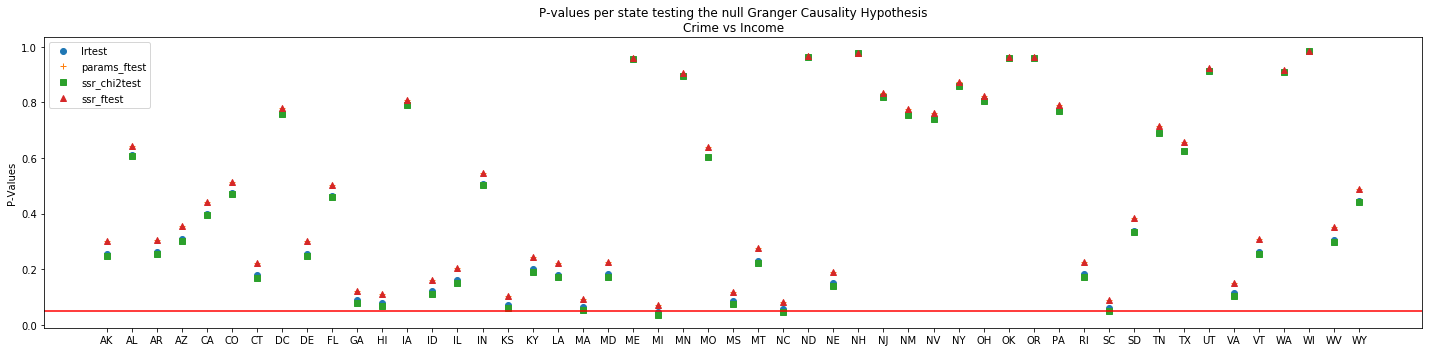

In [62]:
fig, ax = plt.subplots(figsize=(20,5))
markers = ['o', '+', 's', '^']
for i,marker in enumerate(markers):
    ax.plot(granger_crime_income_df.iloc[i], marker=marker,linestyle='None', label=tests[i])
    ax.set_ylabel('P-Values')
plt.axhline(y=0.05, xmin=0, xmax=20, color='r')
plt.title('P-values per state testing the null Granger Causality Hypothesis\nCrime vs Income')
plt.legend()
plt.tight_layout()
plt.show()

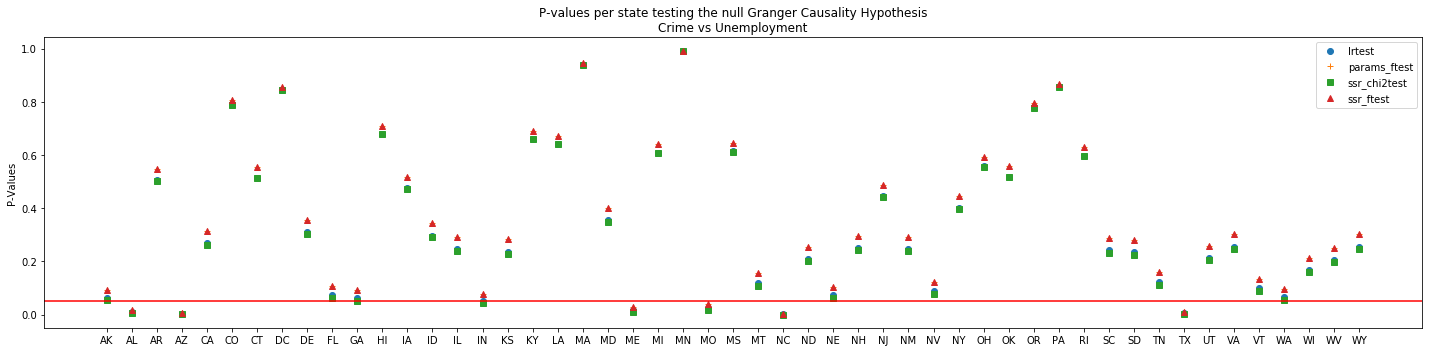

In [61]:
fig, ax = plt.subplots(figsize=(20,5))
markers = ['o', '+', 's', '^']
for i,marker in enumerate(markers):
    ax.plot(granger_crime_unemp_df.iloc[i], marker=marker,linestyle='None', label=tests[i])
    ax.set_ylabel('P-Values')
plt.axhline(y=0.05, xmin=0, xmax=20, color='r')
plt.title('P-values per state testing the null Granger Causality Hypothesis\nCrime vs Unemployment')
plt.legend()
plt.tight_layout()
plt.show()

### Conclusion:

* None of the states shows Granger Causality when comparing crime vs median income.
* A handfull of states showed Granger Causality when comparing crime vs unemployment. The majority did not

We can conclude that unemployment and median income are not good predictors of crime rate in most states of the United States when analysind data form 1995 to 2016.
